<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-low-level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks with Low Level TensorFlow 2

## Objectives

- basics of artificial neurons
- how matrix multiplication is the basis of neural networks
- how loss functions work
- backpropagation
- optimizers
- regression
- classification

### Based on 
* This thread is a crash course on everything you need to know to use TensorFlow 2.0 + Keras for deep learning research: https://twitter.com/fchollet/status/1105139360226140160
* Colab Notebook _tf.keras for Researchers_: https://colab.research.google.com/drive/17u-pRZJnKN0gO5XZmq8n5A2bKGrfKEUg#scrollTo=UHOOlixcQ9Gl
* Effective TensorFlow 2: https://www.tensorflow.org/alpha/guide/effective_tf2
* Writing a custom training loop: https://twitter.com/fchollet/status/1132013928681050113


In [0]:
import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [4]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [0]:
# this should return True even on Colab
assert tf.test.is_gpu_available()

In [0]:
# we have the gpu version of TensorFlow running
assert tf.test.is_built_with_cuda()

In [7]:
# What kind of GPU are we running on
!nvidia-smi

Sat Sep 21 15:08:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# different from TF 1, everything gets executed immediately 
assert tf.executing_eagerly()

## Transforming an input to a known output

In [0]:
input = [[-1], [0], [1], [2], [3], [4]]
output = [[2], [1], [0], [-1], [-2], [-3]]

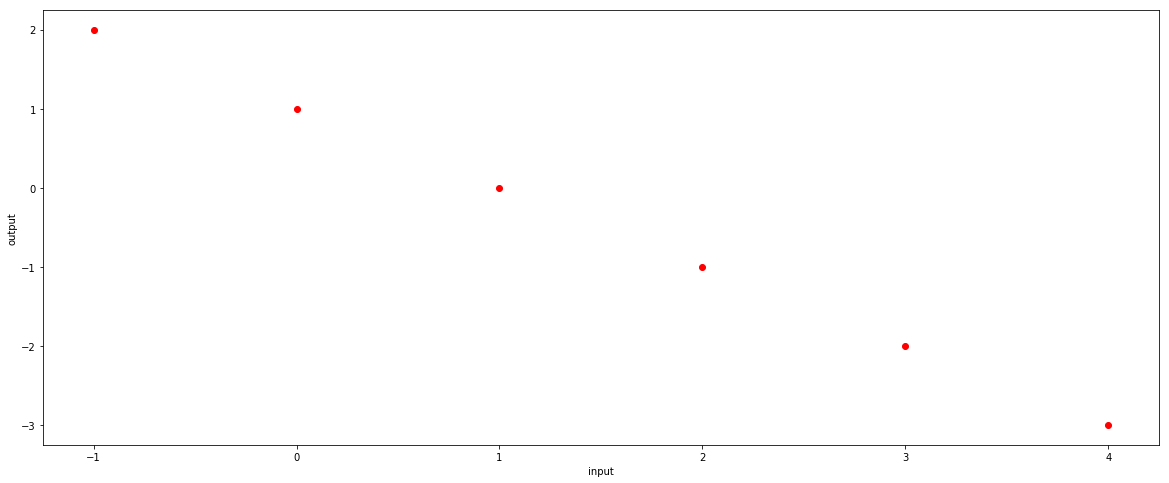

In [10]:
import matplotlib.pyplot as plt

plt.xlabel('input')
plt.ylabel('output')

plt.plot(input, output, 'ro')

### relation between input and output is linear

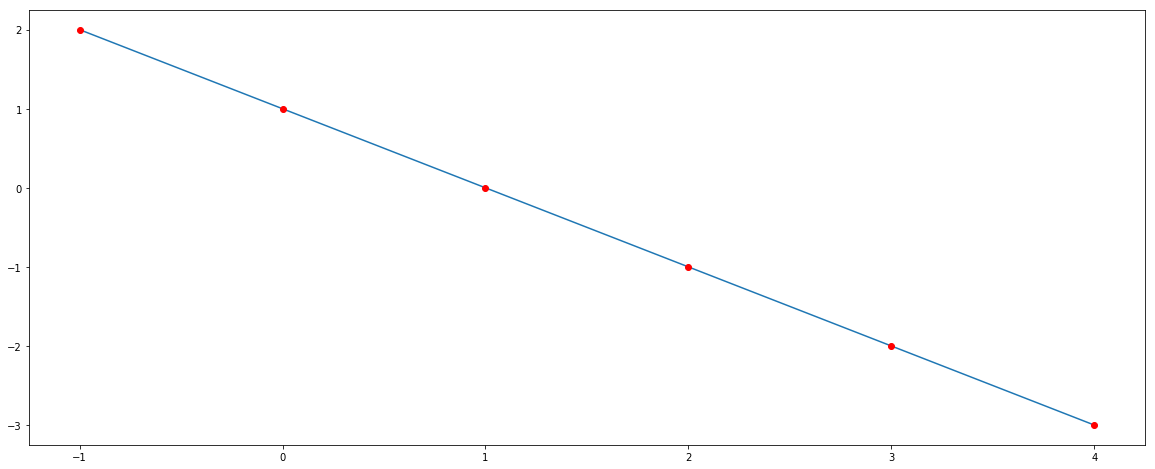

In [11]:
plt.plot(input, output)
plt.plot(input, output, 'ro')

## Training a neural network to model that line

untrained single unit (neuron) can output a line, we just need it to match the parameters of our real line


### The Artificial Neuron: Foundation of Deep Neural Networks (simplified, more later)

* a neuron takes a number of numerical inputs
* multiplies each with a weight, sums up all weighted input and  
* adds bias (constant) to that sum
* from this it creates a single numerical output
* for one input (one dimension) this would be a description of a line
* for more dimensions this describes a hyper plane that can serve as a decision boundary
* this is typically expressed as a matrix multplication plus an addition


<img src='https://djcordhose.github.io/ai/img/insurance/neuron211.jpg'>

### This can be expressed using a matrix multiplication

In [12]:
%%time 

# parameters of the neuron (can be learned), defining the function to apply
w = tf.constant([[1.5], [-2], [1]], dtype='float32')
b = tf.constant([6], dtype='float32')

# variable input being fed through the parameterized neuron
x = tf.constant([[10, 6, 8]], dtype='float32')

# computed output
y = tf.matmul(x, w) + b
print(y)

tf.Tensor([[17.]], shape=(1, 1), dtype=float32)
CPU times: user 395 ms, sys: 200 ms, total: 594 ms
Wall time: 596 ms


### Hands-On: Experiment with our neuron

* execute the notebook up to this cell
* change the values of the input, weights and bias in the cell above
* restart the calculation and make sure the result meets your expectations

## Defining a layer with a random number of neurons and inputs

With a little more work this would be a complete implementation of a fully connected layer



In [13]:
from tensorflow.keras.layers import Layer

# we derive from a TensorFlow Layer
class LinearLayer(Layer):
  """y = w.x + b"""

  # initializing our layer
  def __init__(self, units=1, input_dim=1):
      super(LinearLayer, self).__init__()
      # these are our weights, which can be learned, initialized normally around 0 with stddev of 2
      self.w = tf.Variable(
          initial_value = tf.random_normal_initializer(stddev=2)(shape=(input_dim, units), dtype='float32'),
          trainable=True,
          name='weights')
      # these are our bisases, also can be learned, initialized as 0
      self.b = tf.Variable(
          initial_value = tf.zeros_initializer()(shape=(units,), dtype='float32'),
          trainable=True,
          name='biases')

  # what the layer does (some as in our example before)
  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b
    
# just one neuron and one input (but could be as many as we like)    
linear_layer = LinearLayer()
linear_layer.trainable_variables

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[2.0500681]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### Output of a single untrained neuron

In [14]:
input

[[-1], [0], [1], [2], [3], [4]]

In [15]:
# x and y are typically names for input and output in machine learning
x = tf.constant(input, dtype=tf.float32)
x

<tf.Tensor: id=32, shape=(6, 1), dtype=float32, numpy=
array([[-1.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.]], dtype=float32)>

In [16]:
output

[[2], [1], [0], [-1], [-2], [-3]]

In [17]:
y_true = tf.constant(output, dtype=tf.float32)
y_true

<tf.Tensor: id=33, shape=(6, 1), dtype=float32, numpy=
array([[ 2.],
       [ 1.],
       [ 0.],
       [-1.],
       [-2.],
       [-3.]], dtype=float32)>

In [18]:
# we use our layer from above to make a prediction for x
y_pred = linear_layer(x)
y_pred

<tf.Tensor: id=37, shape=(6, 1), dtype=float32, numpy=
array([[-2.0500681],
       [ 0.       ],
       [ 2.0500681],
       [ 4.1001363],
       [ 6.1502047],
       [ 8.200273 ]], dtype=float32)>

In [19]:
# obviously we are really off (no wonder as the parameters are just random)
y_true - y_pred

<tf.Tensor: id=38, shape=(6, 1), dtype=float32, numpy=
array([[  4.050068 ],
       [  1.       ],
       [ -2.0500681],
       [ -5.1001363],
       [ -8.150205 ],
       [-11.200273 ]], dtype=float32)>

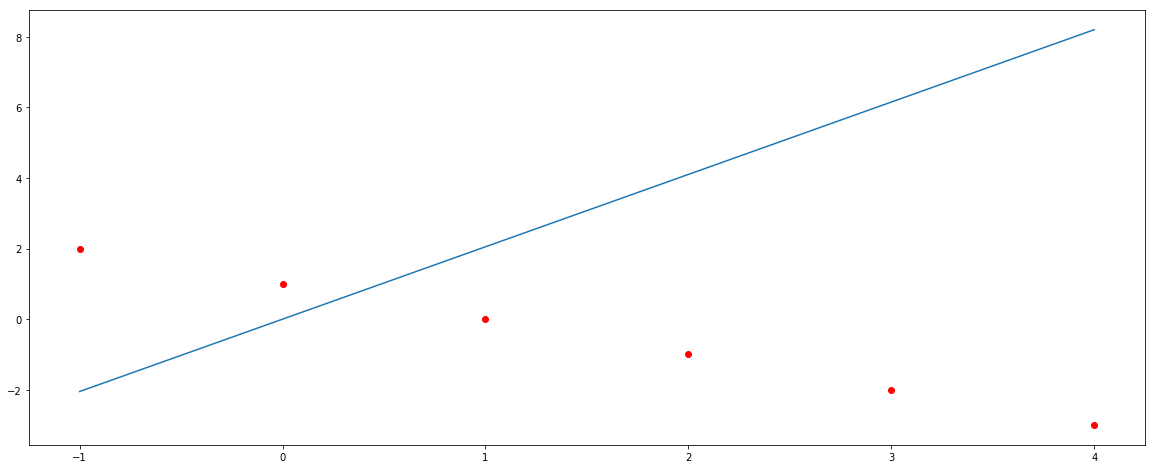

In [20]:
# let's see how off we are
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')

In [21]:
# you can see slope and offset are just not right
slope = linear_layer.w; offset = linear_layer.b
slope, offset

(<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[2.0500681]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)

### Hands-On: create your own version of the neuron

* run the cells above
* how does your line look like?
* why is it different?
* why is the bias always the same?

## How wrong are we?

Our neuron does not output the correct line. To fix this we first need to have a measure of how fare we are off



### Loss aka Error

Loss function is the prerequisite to training. We need an objective to optimize for. We calculate the difference between what we get as output and what we would like to get.

### Mean Squared Error

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


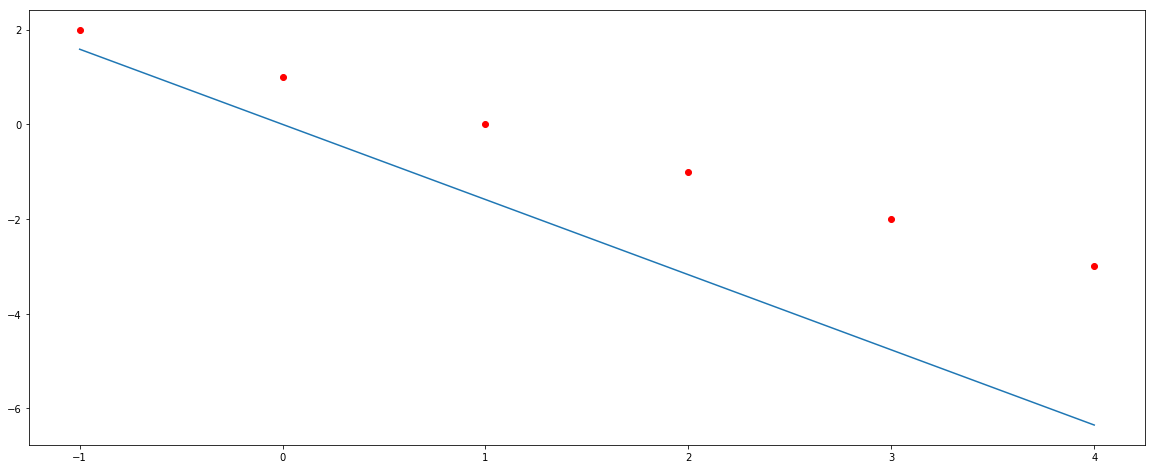

In [22]:
# make sure we have a fresh single neuron
linear_layer = LinearLayer()
y_pred = linear_layer(x)
plt.plot(x, y_pred)
plt.plot(input, output, 'ro');

In [0]:
# we could also use absolut error which would give less weight to outliers
loss_fn = tf.losses.mean_squared_error
# loss_fn = tf.losses.mean_absolute_error

In [0]:
assert tf.keras.losses.mean_squared_error == tf.losses.mean_squared_error

In [25]:
# how bad is it, really?
loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
print(loss)

tf.Tensor(4.544622, shape=(), dtype=float32)


In [26]:
# mse is not speaking

# R^2 score, the closer to 1 the better
# loosely speaking: how much better is this than predicting the constant mean
# 0 would mean just as good
# 1 is perfect
# neg. would mean even worse
# it can become arbitrarily worse
# https://en.wikipedia.org/wiki/Coefficient_of_determination

from sklearn.metrics import r2_score
r2 = r2_score(y_true.numpy(), y_pred.numpy())
r2

-0.5581560722419194

## Backpropagation algorithm


### The core of how a neural network learns

_In a nutshell:_
1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. Record a function of how the trainable parameters affect the loss 
1. partial derivations: find out in which direction to change all parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters


### Loss depends on the trainable variables, in our case two parameters: weight and bias

This is how the loss function might change depending on those variables

<img src='https://djcordhose.github.io/ai/img/gradients.jpg'>

https://twitter.com/colindcarroll/status/1090266016259534848

In [27]:
linear_layer.trainable_variables

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[-1.5873693]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### For this we need partial derivations

TensorFlow offers automatic differentiation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

* tape will record operations for automatic differentiation
* either by making it record explicily (watch) or 
* by declaring a varible to be trainable (which we did in the layer above) 



In [0]:
from tensorflow import GradientTape 
GradientTape?

In [29]:
def tape_sample():
  x = tf.constant(3.0)
  with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
  print(x, y)
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print(dy_dx)
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

tf.Tensor(3.0, shape=(), dtype=float32) tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


### Short Exercise: create your own example

* first understand the example above: do the values make sense to you?
* change the value for x
* create your own function
* add another variable y depdends on

## If you really want to understand how this works (very much optional)

In a multi layer network the chain rule is used to find out how an intermediate neuron affects the overall error

### How does the loss (f) change when changing either a or b?

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/loss_f_a_b.png?raw=1'>

### Calculating df/da

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/chain_rule_a.png?raw=1'>

### Calculating df/db

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/chain_rule_b.png?raw=1'>

https://twitter.com/random_forests

https://towardsdatascience.com/back-propagation-demystified-in-7-minutes-4294d71a04d7



In [30]:
def tape_sample():
  with GradientTape() as tape:
    a = tf.constant(2.0)
    b = tf.constant(1.0)
    tape.watch(a)
    tape.watch(b)
    c = a + b
    d = b + 1
    f = c * d
  print(a, b, c, d, f)
  # how is f dependending on the other variables
  (df_da, df_db, df_dc, df_dd, df_df) = tape.gradient(f, [a, b, c, d, f])
  print(df_da)
  print(df_db)
  print(df_dc)
  print(df_dd)
  print(df_df)
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(3.0, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


### Hands-On: Work through the above example

* above you see the calculation of df/da and df/db
* make sure you understand how it is composed based on the different rules you see on the left side
* make changes to variables and how they are computed and make sure you will understand the results
* if you understand what is going on, help your neighbors

### Applying backprop to a complex network

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/backprop.png?raw=1'>

From https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/

More resources to understand back propagation
* Mathematical
  * http://cs231n.github.io/optimization-2/
  * http://neuralnetworksanddeeplearning.com/chap2.html
* Intuitive: http://colah.github.io/posts/2015-08-Backprop/
* Maths basics: https://www.mathsisfun.com/calculus/derivatives-rules.html  

## Appying Backpropagation to actually train our network

https://twitter.com/fchollet/status/1132013928681050113

In [31]:
linear_layer = LinearLayer()
linear_layer.w, linear_layer.b

(<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[1.2992471]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)

In [32]:
linear_layer.trainable_weights

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[1.2992471]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### We follow the backpropagation algorithm from above

1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. Record a function of how the trainable parameters affect the loss 
1. partial derivations: find out in which direction to change all parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters


### Job of the optimizer: Minimize Loss by changing parameters of neuron 

<img src='https://djcordhose.github.io/ai/img/manning/optimizer.png' height=500>

In [0]:
linear_layer = LinearLayer()

EPOCHS = 500
learning_rate = 1e-2

losses = []

In [0]:
for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    # often we do not use all data to calculate the loss, but only a certain fraction, called the batch
    # you could also push data through one by one, being an extreme version of a batched approached
    # in our case we use all the data we have and calculate the combined error
    y_pred = linear_layer(x)

    # loss for this batch
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)

  # get gradients of weights wrt the loss
  (dw, db) = tape.gradient(loss, linear_layer.trainable_weights)
  
  # optimizer: backward pass, changing trainable weights in the direction of the mimimum
  linear_layer.w.assign_sub(learning_rate * dw)
  linear_layer.b.assign_sub(learning_rate * db)

In [35]:
print(loss)

tf.Tensor(0.00013399207, shape=(), dtype=float32)


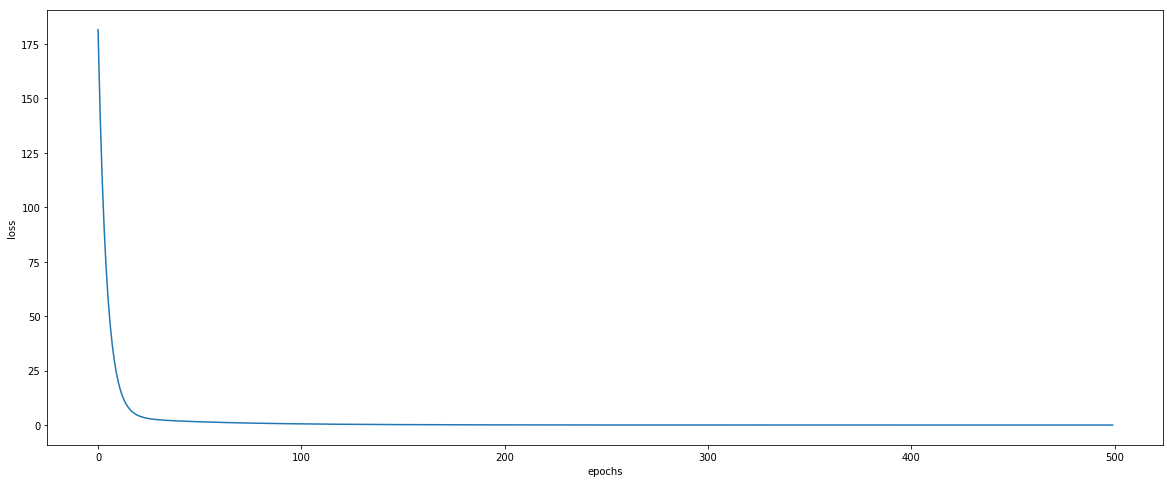

In [36]:
plt.xlabel('epochs')
plt.ylabel('loss')

# plt.yscale('log')

plt.plot(losses)

### Line drawn by neuron after training

* result after training is not perfect, but almost looks like the same line
* https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form


In [37]:
y_pred = linear_layer(x)
y_pred

<tf.Tensor: id=20242, shape=(6, 1), dtype=float32, numpy=
array([[ 1.9799299 ],
       [ 0.9848246 ],
       [-0.01028067],
       [-1.0053859 ],
       [-2.0004911 ],
       [-2.9955964 ]], dtype=float32)>

In [38]:
y_pred - y_true

<tf.Tensor: id=20243, shape=(6, 1), dtype=float32, numpy=
array([[-0.02007008],
       [-0.0151754 ],
       [-0.01028067],
       [-0.00538588],
       [-0.00049114],
       [ 0.00440359]], dtype=float32)>

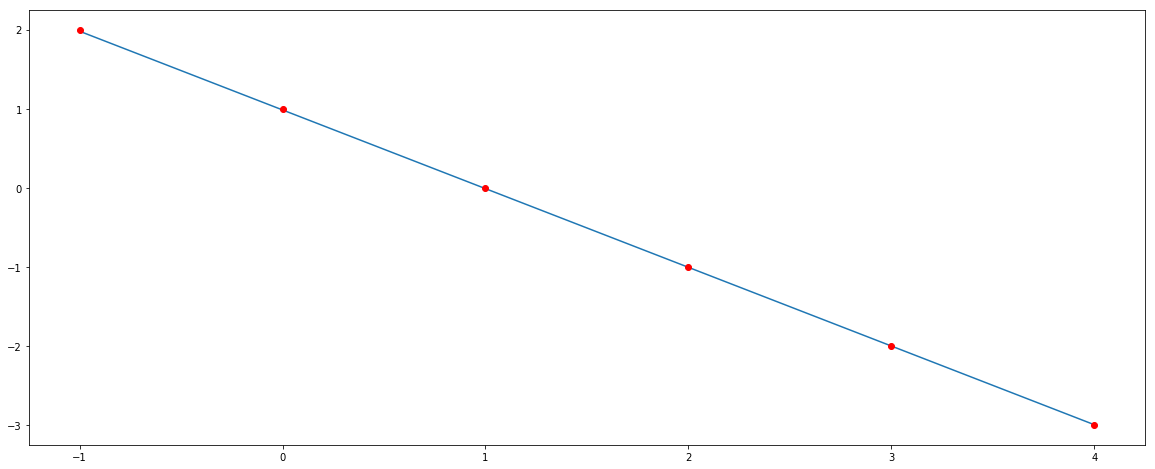

In [39]:
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')

In [40]:
# single neuron and single input: one weight and one bias
# slope m ~ -1 = weight
# y-axis offset y0 ~ 1 = bias
# https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form

linear_layer.w, linear_layer.b

(<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[-0.99510527]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.9848246], dtype=float32)>)

In [41]:
# this should be pretty close to 1
r2 = r2_score(y_true.numpy(), y_pred.numpy())
r2

0.999955003804072

### Hands-On: Train your model to good results

* with the cells above check that the variables are reasonably close to what we know this is right
* understand that this is not an option your normally have
* the number of epochs to train and the learning rate to see how close you can get to the true result

## Prebuilt Optimizers do this job (but a bit more efficient and sohpisticated)

* http://cs231n.github.io/optimization-1/
* http://cs231n.github.io/neural-networks-3/#update
* How they sound: http://blog.christianperone.com/2019/08/listening-to-the-neural-network-gradient-norms-during-training/

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

In [0]:
EPOCHS = 500

losses = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = linear_layer(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  losses.append(loss)
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

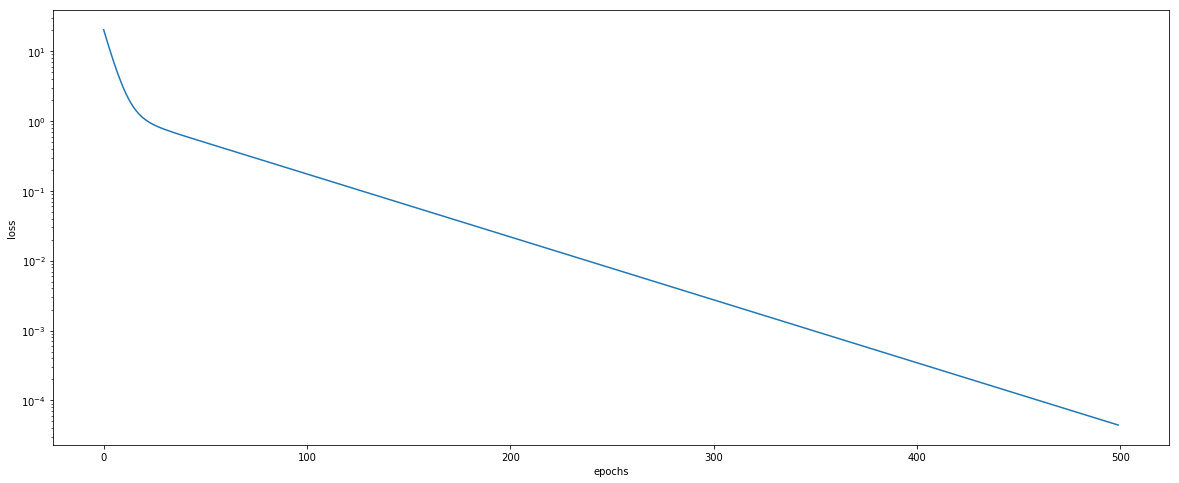

In [44]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses)

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[-0.997187]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.9912789], dtype=float32)>]

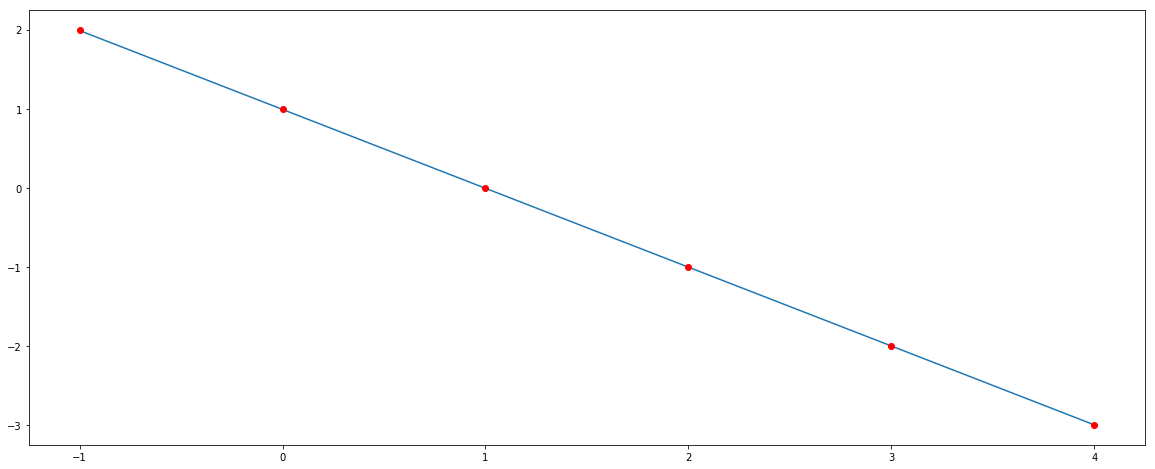

In [45]:
y_pred = linear_layer(x)
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')
linear_layer.trainable_weights

In [46]:
r2 = r2_score(y_true.numpy(), y_pred.numpy())
r2

0.9999851392173014

## A more realistic Example: More data points, more noisy (optional)

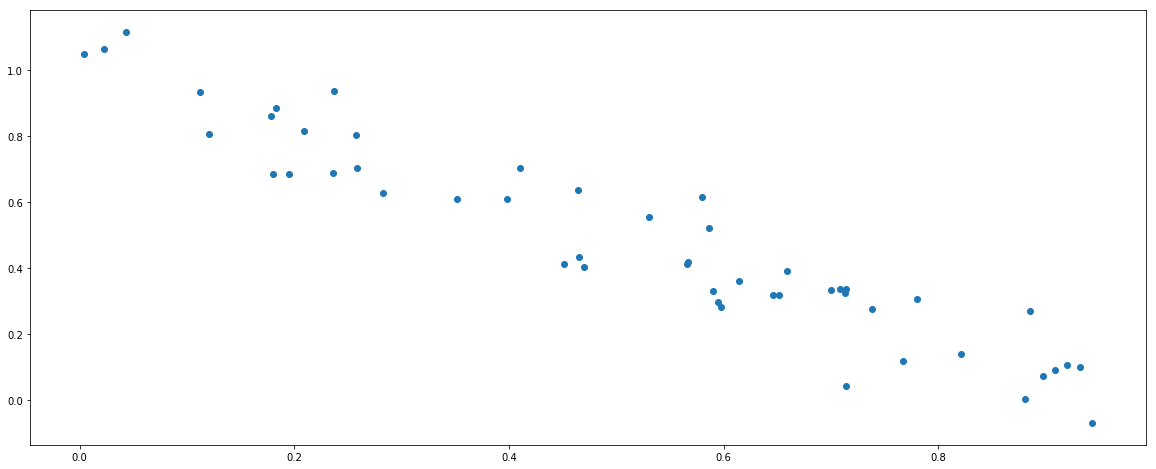

In [47]:
import numpy as np

a = -1
b = 1
n = 50
noise = 0.1


x = tf.constant(np.random.uniform(0, 1, n), dtype='float32')
y = tf.constant(a*x+b + np.random.normal(0, noise, n), dtype='float32')

plt.scatter(x, y)

In [0]:
x = tf.reshape(x, (n, 1))
y_true = tf.reshape(y, (n, 1))

(<Figure size 1440x576 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7f27ed72f390>])

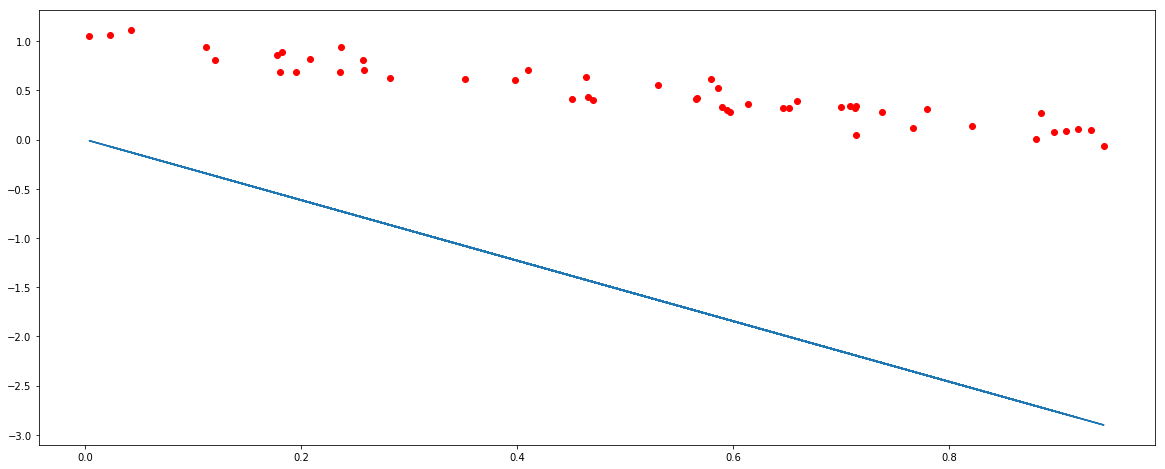

In [49]:
linear_layer = LinearLayer()

a = linear_layer.w.numpy()[0][0]
b = linear_layer.b.numpy()[0]

def plot_line(a, b, x, y_true):
  fig, ax = plt.subplots()
  y_pred = a * x + b
  
  line = ax.plot(x, y_pred)
  ax.plot(x, y_true, 'ro')
  return fig, line

plot_line(a, b, x, y_true)

In [0]:
# the problem is a little bit harder, train for a little bit longer
EPOCHS = 2000

losses = []

# stores intermediate versions of our line
lines = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = linear_layer(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  losses.append(loss)
  
  a = linear_layer.w.numpy()[0][0]
  b = linear_layer.b.numpy()[0]
  lines.append((a, b))
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

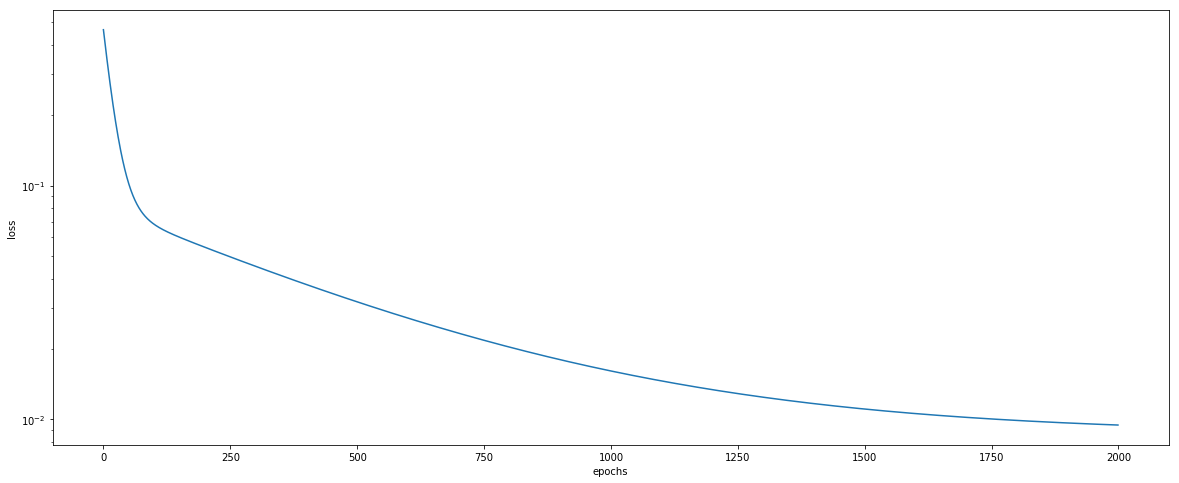

In [51]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses)

In [52]:
y_pred = linear_layer(x)

r2 = r2_score(y_true.numpy(), y_pred.numpy())
r2

0.8930456104374519

### What lines the model draws over time

#### After 0, 500, 100 steps

Text(0.5, 1.0, '0')

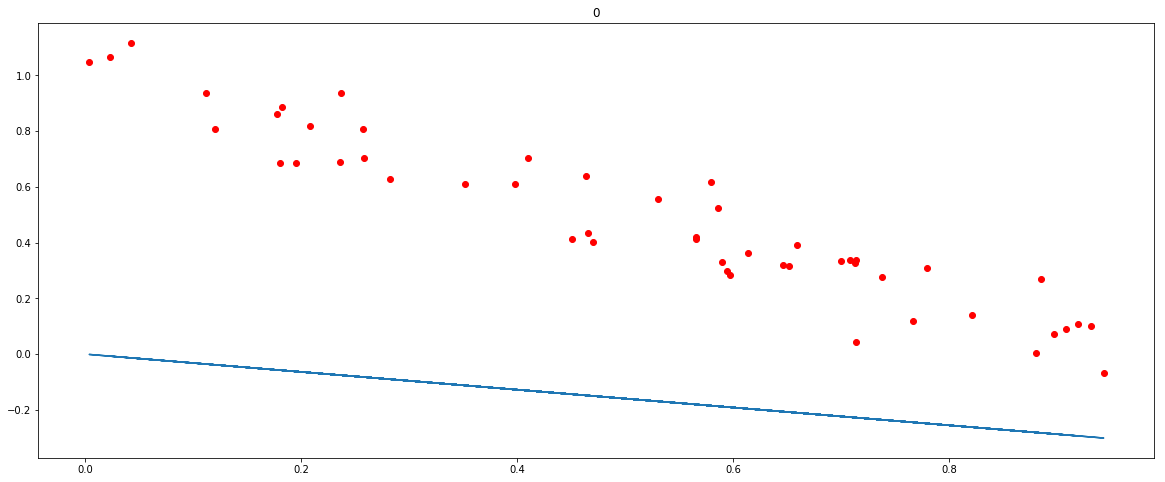

In [53]:
a, b = lines[0]

plot_line(a, b, x, y_true)
plt.title('0')

Text(0.5, 1.0, '500')

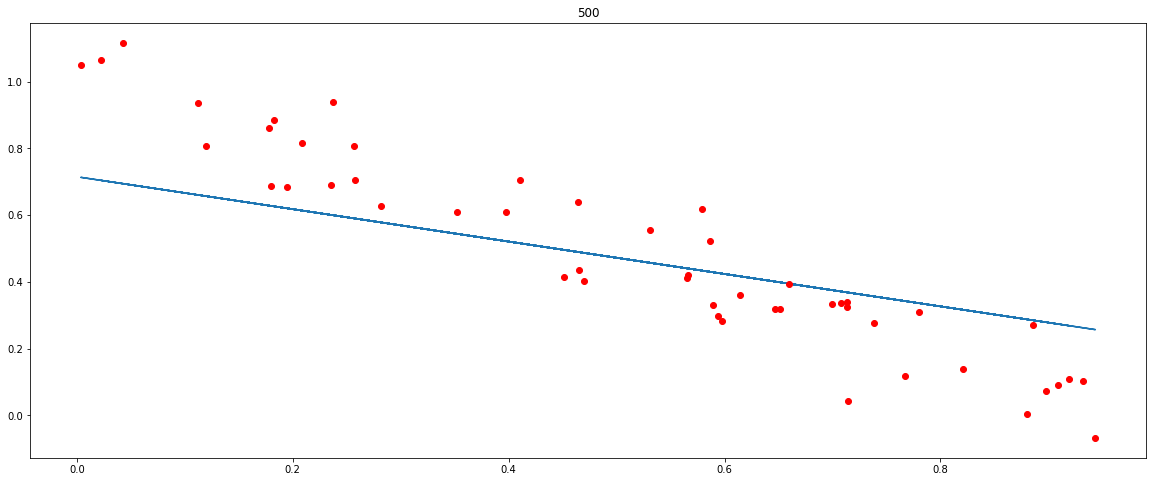

In [54]:
a, b = lines[500]

plot_line(a, b, x, y_true)
plt.title('500')

Text(0.5, 1.0, '1000')

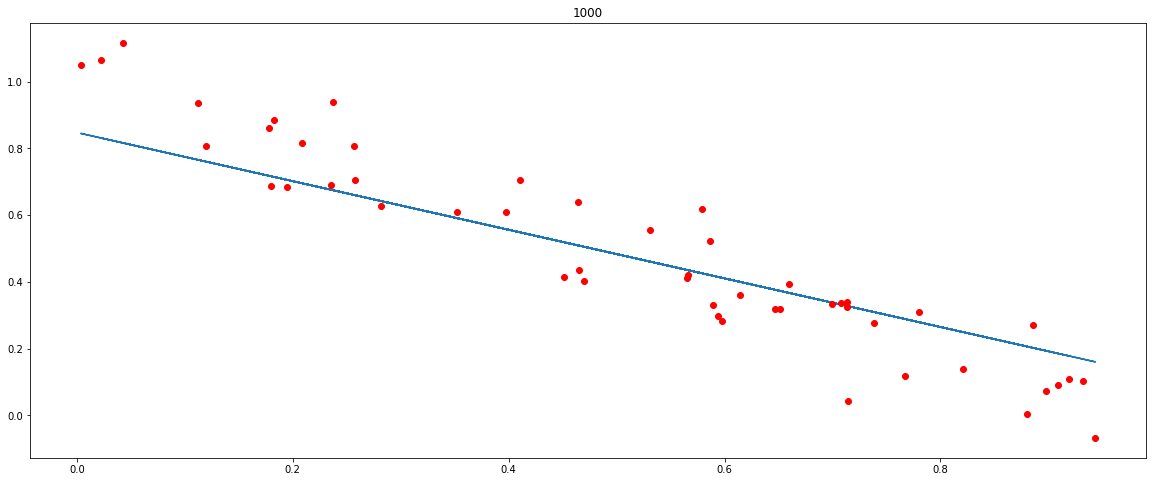

In [55]:
a, b = lines[1000]

plot_line(a, b, x, y_true)
plt.title('1000')

Text(0.5, 1.0, '2000, Final')

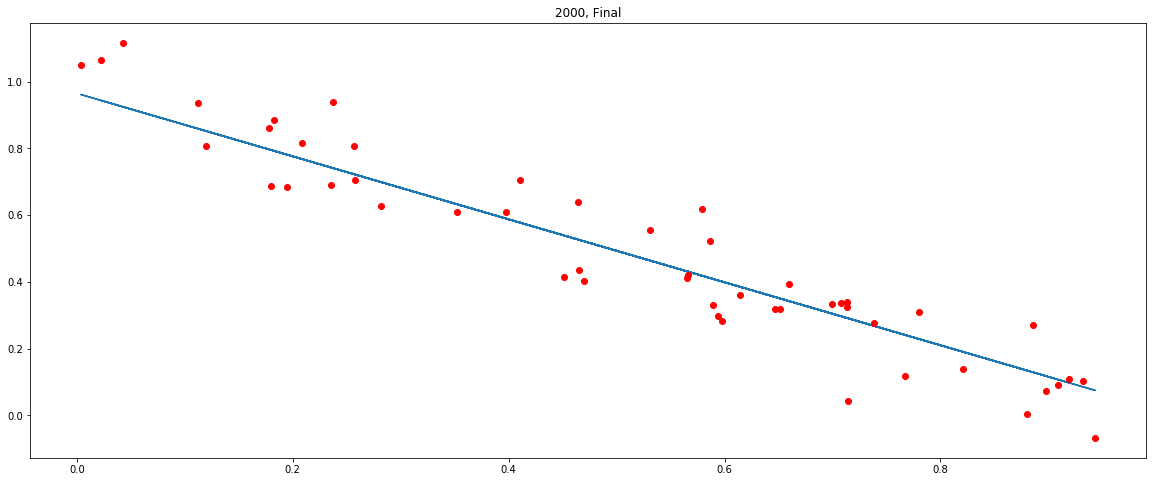

In [56]:
a, b = lines[1999]

plot_line(a, b, x, y_true)
plt.title('2000, Final')

### Exercise: Re-Run experiment with more noise

* run the cells above and train our model
* change the noise of the line and make it less line like
* can you still get good training results?
* how would you know? how is the loss changing?

## The same solution using high level Keas API

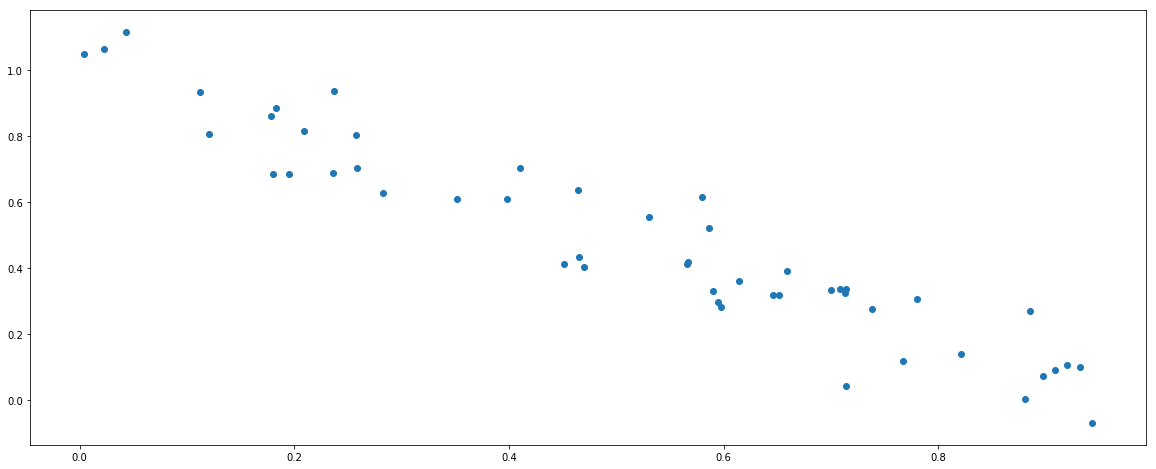

In [57]:
plt.scatter(x, y);

In [58]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)                   
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
# adapted from https://stackoverflow.com/a/42351397/1756489 and ported to TF 2
# https://keras.io/metrics/#custom-metrics

def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
  
  return R_squared

In [60]:
%%time 

model.compile(loss=loss_fn, # mean squared error, unchanged from low level example
             optimizer=optimizer, # adam, unchanged from low level example
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y_true, epochs=EPOCHS, verbose=0)

CPU times: user 17.9 s, sys: 1.55 s, total: 19.4 s
Wall time: 14 s


In [61]:
loss, r2 = model.evaluate(x, y_true, verbose=0)
loss, r2

(0.008682610243558883, 0.8930875)

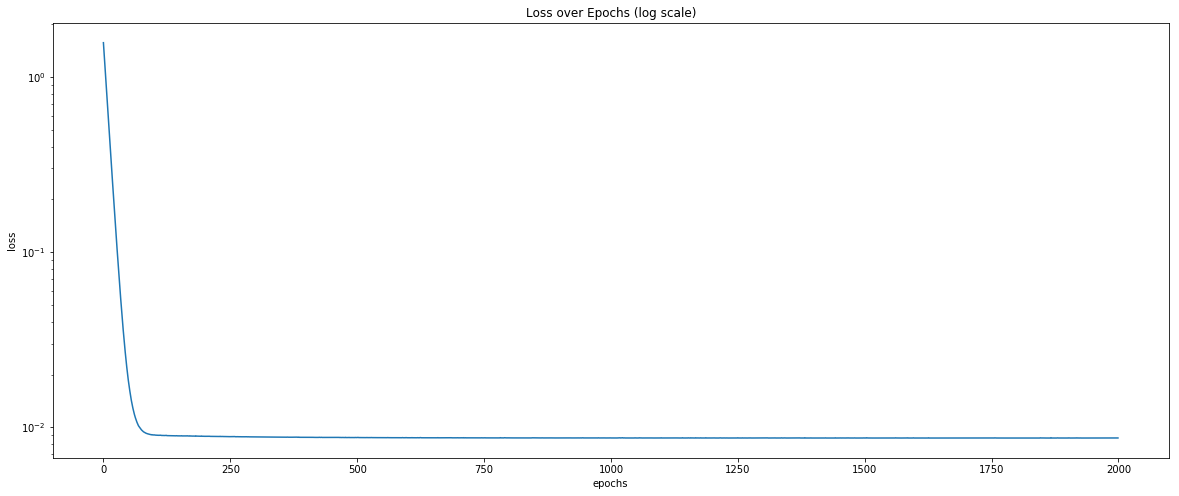

In [62]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs (log scale)')

plt.plot(history.history['loss']);

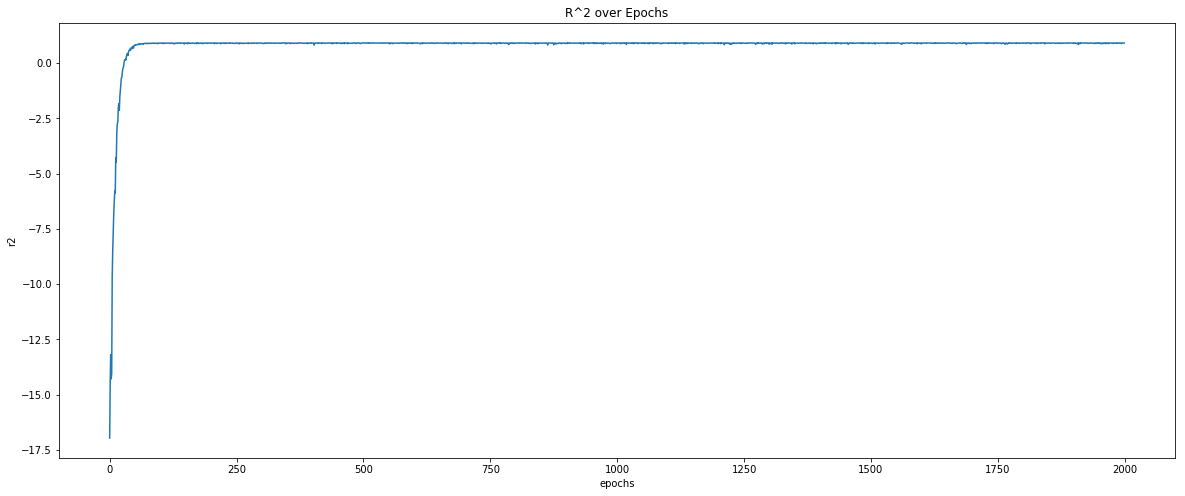

In [63]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')

plt.plot(history.history['r2_metric']);

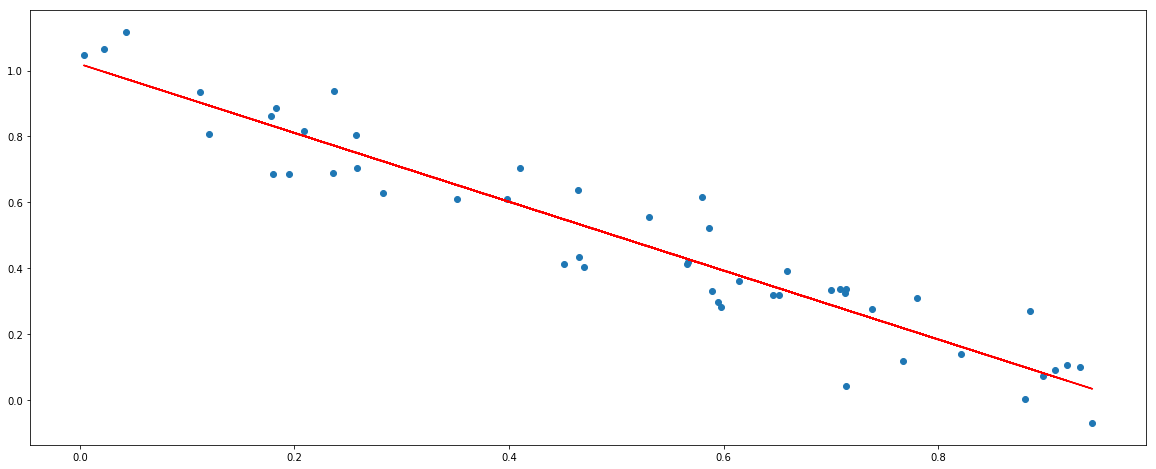

In [64]:
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red')
plt.scatter(x, y);